In [1]:
import marvin
marvin.config.download = True
marvin.config.release = 'DR17'

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as sci
plt.ion()

from marvin.tools.vacs import VACs
from astropy.io import fits
import numpy as np
from marvin.tools import Maps
from marvin.tools import Cube

from marvin import config #Needed to fix "Cube not subscriptable" when running in Sciserver
config.forceDbOff() #Needed to fix "Cube not subscriptable" when running in Sciserver

print('Marvin and Matplotlib imported. Warnings about missing paths/files are typical, so no need to be concerned')

/home/idies/miniconda3/envs/py38/lib/python3.8/site-packages/marvin/core/exceptions.py:50: UserWarning: cannot initiate Sentry error reporting: [Errno 6] No such device or address.
  warnings.warn('cannot initiate Sentry error reporting: {0}.'.format(str(ee)),
[INFO]: No release version set. Setting default to DR17
[WARNING]: path /home/idies/workspace/sdss_sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /home/idies/workspace/sdss_sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)


Marvin and Matplotlib imported. Warnings about missing paths/files are typical, so no need to be concerned


In [2]:
pipe3d = 'https://data.sdss.org/sas/dr17/manga/spectro/pipe3d/v3_1_1/3.1.1/8263/manga-8263-12705.Pipe3D.cube.fits.gz'
#to get a pipe3D fits file for a specific galaxy change the number after 3.1.1. to the MaNGA plate number and the numbers after manga- with the plateifu value
hdu=fits.open(pipe3d)
mass=hdu[1].data[19] #dust corrected stellar mass density
error=hdu[1].data[20]
mask=hdu[8].data
gaia=hdu[7].data
mangaid = '8263-12705' #MaNGA plate-ifu of the galaxy
maps = marvin.tools.Maps(mangaid)
data = maps.vacs.gz3d

In [3]:
style = {
    'lines.linewidth': 1.5,
    'font.size': 16.0,
    'axes.linewidth': 1.5,
    'axes.titlesize': 'large',
    'axes.labelsize': 'large',
    'xtick.major.size': 6,
    'xtick.minor.size': 4,
    'xtick.major.width': 1.5,
    'xtick.minor.width': 1.5,
    'xtick.major.pad': 6,
    'xtick.minor.pad': 6,
    'xtick.labelsize': 'medium',
    'ytick.major.size': 6,
    'ytick.minor.size': 4,
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1.5,
    'ytick.major.pad': 6,
    'ytick.minor.pad': 6,
    'ytick.labelsize': 'medium',
    'legend.fancybox': True,
    'legend.fontsize': 'small',
    'legend.scatterpoints': 5,
    'legend.loc': 'best',
    'figure.titlesize': 'large',
}

plt.style.use(style)

In [4]:
#removing bad spaxels
m=mass*mask
mask_m=np.where(m==0,np.nan,m)

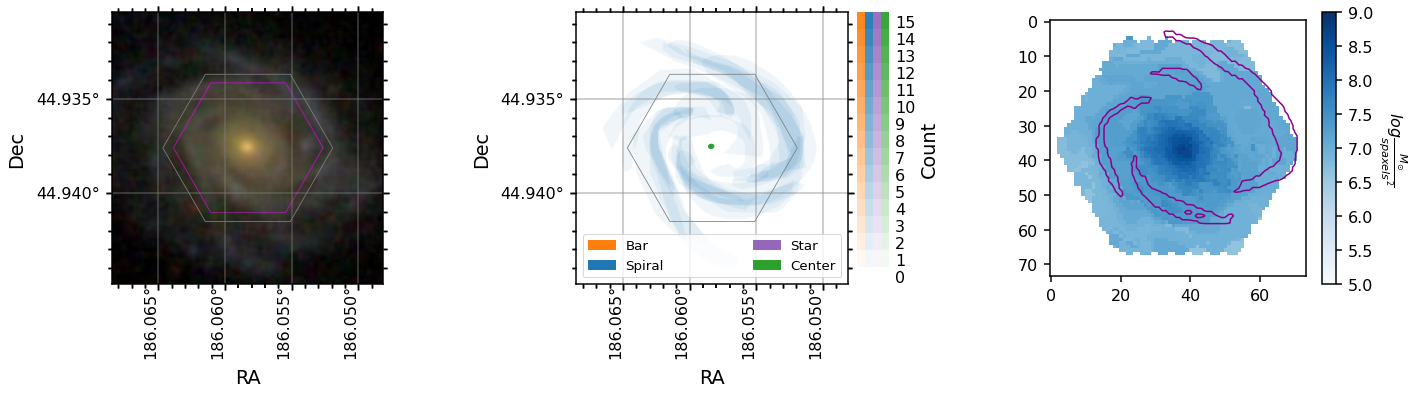

In [5]:
#Setting up the plot
plt.figure(figsize=(23, 5))
gs = gridspec.GridSpec(1, 3, wspace=0.5)
ax0 = plt.subplot(gs[0], projection=data.wcs)

#Plot the orignal image shown to GZ3D volunteers
data.plot_image(color_grid='grey', ax=ax0)

#Plot a heat map showing vote counts for the four different tasks in GZ3D. We call these feature masks. 
data.plot_masks(color_grid='grey', subplot_spec=gs[1]);

#As above, but overlay on the image
ax=plt.subplot(gs[2])
plt.imshow(mask_m,cmap='Blues',vmax=9,vmin=5)
cb=plt.colorbar(location='right')
cb.set_label(r'$log\frac{M_{\odot}}{{spaxels}^2}$',labelpad=35,loc='center',rotation=270,size='medium')
#ax.set_title('Pipe3D Stellar Mass Density')
ax.contour(data.spiral_mask_spaxel, levels=[4.5], zorder=20, colors='darkmagenta',alpha=1,lw=6)

#plot1 = 'oneGex.pdf'
#plt.savefig(plot1, bbox_inches='tight')

In [6]:
#removing spaxels with foreground stars
indexes0=np.array([])
indexes1=np.array([])
for i in range(len(gaia)):
    for j in range(len(gaia[i])):
        if gaia[i][j]==1:
            indexes0=np.append(indexes0,i)
            indexes1=np.append(indexes1,j)
            
if len(indexes0)!=0:
    for i in indexes0:
        for i in indexes1:
            mask_m[int(i)][int(j)]=np.nan

In [7]:
#getting location of spiral arm spaxels
galaxy = data.spiral_mask_spaxel

In [8]:
#getting the values for stellar mass of arm vs interarm spaxels
max_a=np.max(galaxy)
inter=max_a*0.3
ar=max_a*0.5
arm = np.where(galaxy > ar,1,np.nan)
interarm = np.where(galaxy < inter,1,np.nan)
ma = mask_m*arm
mi= mask_m*interarm

Text(0.5, 1.0, 'Combined')

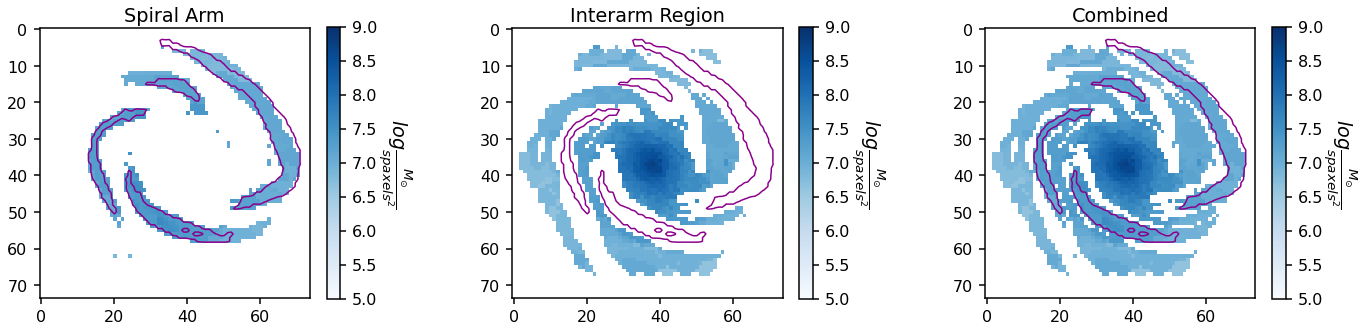

In [9]:
#Setting up the Multiplot
fig,axs = plt.subplots(1, 3, figsize=(23, 5))
gs = gridspec.GridSpec(1, 3, fig, wspace=0.4)

#Spiral arm stellar mass plot
ax0 = plt.subplot(gs[0])
plt.imshow(ma, vmin=5, vmax=9,cmap='Blues')
ax0.contour(data.spiral_mask_spaxel, levels=[4.5], zorder=20, colors='darkmagenta')
#ax0.set_ylim(*ax0.get_ylim()[::-1])
cb=plt.colorbar(location='right')
cb.set_label(r'$log\frac{M_{\odot}}{{spaxels}^2}$',labelpad=35,loc='center',rotation=270,size='large')
ax0.set_title('Spiral Arm',size='large')

#Interarm region 
ax1 = plt.subplot(gs[1])
plt.imshow(mi, vmin=5, vmax=9,cmap='Blues')
ax1.contour(data.spiral_mask_spaxel, levels=[4.5], zorder=20, colors='darkmagenta')
#ax1.set_ylim(*ax1.get_ylim()[::-1])
cb=plt.colorbar(location='right')
cb.set_label(r'$log\frac{M_{\odot}}{{spaxels}^2}$',labelpad=35,loc='center',rotation=270,size='large')
ax1.set_title('Interarm Region',size='large')

#Combined plot
ax2 = plt.subplot(gs[2])
ax2.imshow(mi,vmin=5, vmax=9,cmap='Blues')
ax2.imshow(ma,vmin=5, vmax=9,cmap='Blues')
ax2.contour(data.spiral_mask_spaxel, levels=[4.5], zorder=20, colors='darkmagenta')
#ax2.set_ylim(*ax2.get_ylim()[::-1])
cb=plt.colorbar(location='right')
cb.set_label(r'$log\frac{M_{\odot}}{{spaxels}^2}$',labelpad=35,loc='center',rotation=270,size='large')
ax2.set_title('Combined',size='large')

#plot1 = 'Mask_and_data.pdf'
#plt.savefig(plot1, bbox_inches='tight')

In [10]:
radius = maps.spx_ellcoo_r_re
bins=25
drange=[0,3.0]

#masks to pick out arm spaxels and compare them to the general average
mask=np.where(np.isnan(ma),0,1)
mask2=np.where(np.isnan(mask_m),0,1)

#finding averages for arm vs all spaxels
mass_ma,radius_ma,binnumber = sci.binned_statistic(radius.value[mask!=0],ma[mask!=0],bins=bins,range=drange)
mass_all,radius_all,binnnumber = sci.binned_statistic(radius.value[mask2!=0],mask_m[mask2!=0],bins=bins,range=drange)
count_ma,radius_ma,binnumber = sci.binned_statistic(radius.value[mask!=0],ma[mask!=0],bins=bins,range=drange,statistic='count')
sigmass_ma,radius_ma,binnumber = sci.binned_statistic(radius.value[mask!=0],ma[mask!=0],bins=bins,range=drange,statistic='std')
count_all,radius_all,binnumber = sci.binned_statistic(radius.value[mask2!=0],mask_m[mask2!=0],bins=bins,range=drange,statistic='count')
sigmass_all,radius_all,binnumber = sci.binned_statistic(radius.value[mask2!=0],mask_m[mask2!=0],bins=bins,range=drange,statistic='std')

(-0.5, 1.9)

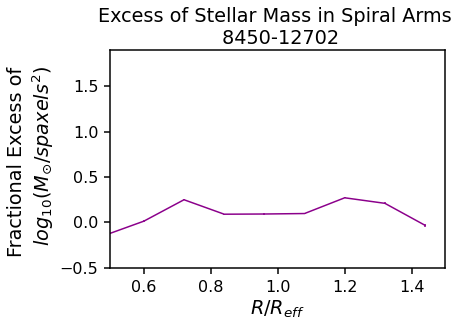

In [11]:
plt.plot()
plt.title('Excess of Stellar Mass in Spiral Arms \n 8450-12702')
plt.xlabel(r'$ R/R_{eff}$')
plt.ylabel('Fractional Excess of \n $log_{10}(M_{\odot}/spaxels^2)$')
f=(10**(mass_ma)-10**(mass_all))/(10**(mass_all))
plt.errorbar(radius_ma[:-1],f,yerr=np.sqrt((sigmass_ma/np.sqrt(2*count_ma))**2+(sigmass_all/np.sqrt(2*count_all))**2),c='darkmagenta')
plt.xlim(0.5,1.5)
plt.ylim(-0.5,1.9)